# JWST NIRSpec MOS data

Simple DRAFT demo notebook to view NIRSpec MOS data. In this first draft, we'll just look at the extracted 2D and 1D spectra from a single object. We'll assume you've already downloaded the s2d and x1d data from MAST (or produced them by rerunning the JWST pipeline).

See also: 
* NIRSpec MAST Query: https://github.com/spacetelescope/dat_pyinthesky/blob/main/jdat_notebooks/NIRSpec_MAST_Query/NIRSpec_MAST_Query.ipynb
* MOSViz: https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html
* NIRSpec MOS pipeline caveats: https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats
* JDAT: https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis/data-analysis-example-jupyter-notebooks
* files: https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html

NIRSpec plotting examples:
* https://github.com/spacetelescope/jwst-caveat-examples/blob/main/NIRSPEC_IFU/ero_nirspec_ifu_02732_demo.ipynb
* https://github.com/spacetelescope/jwst-caveat-examples/blob/main/NIRSPEC_MOS/nrs_mos_clean_1f_noise_workaround.ipynb
* https://github.com/spacetelescope/jwebbinar_prep/blob/faf56cd5f2cadca15e72be4180cd7f957ff3b1d8/mos_session/jwebbinar7_nirspecmos.ipynb
* https://github.com/gbrammer/msaexp/blob/d7368560cf465a0828e942454cfcc0bbe6870278/msaexp/utils.py#L1971

## JWST ERO program 2736: SMACS0723 – JWST's "First Deep Field"

https://webbtelescope.org/contents/news-releases/2022/news-2022-035

Press release featured objects:  
 4590 z = 8.498 (13.1 Gyr ago)  
10612 z = 7.663 (13.0 Gyr ago)  
 8140 z = 5.275 (12.6 Gyr ago)  
 9922 z = 2.743 (11.3 Gyr ago)  
and a few others:  
6355 z = 7.665  ** We'll look at this one ** excellent spectrum with bright lines  
5144 z = 6.383  

Observations:
* two pointings: s007, s008  
* G235M & G395M
* 3 slitlet nods x 2 integrations x 20 groups NRSIRS2 = 8841 s exposure time = 2.5 hours

# Import packages

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

In [3]:
cmap = 'RdBu'
bad_lum = 0.88
bad_color = bad_lum, bad_lum, bad_lum

In [4]:
import jwst
from jwst import datamodels

# 2D and 1D spectrum

Load s2d and x1d files from all exposures combined by Spec3Pipeline

In [5]:
source_id = 6355
data_dir = os.path.join('../data', 's%05d' % source_id)
s2d_file = 'jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'
s2d_file = os.path.join(data_dir, s2d_file)
print(s2d_file, os.path.exists(s2d_file))

x1d_file = s2d_file.replace('s2d', 'x1d')
print(s2d_file, os.path.exists(s2d_file))

../data/s06355/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits True
../data/s06355/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits True


In [6]:
# load as datamodels
s2d_model = datamodels.open(s2d_file) 
x1d_model = datamodels.open(x1d_file) 

In [7]:
#def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='viridis', bad_color=(1,0.7,0.7), min_percent=2, max_percent=99.9, ymin=-2e-6, ymax=1e-5):
def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='RdBu', bad_color='w'): #, bad_color=(0.88,0.88,0.88)):
    # 2D spectrum
    #if source_id:  # s2d has all the objects; extract the one with source_id
    if 'slits' in list(s2d_model):  # s2d has all the objects; extract the one with source_id
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = s2d_model.slits[i_slit]
    else:  # s2d only has one object
        slit_model = s2d_model
        i_slit = 0
        
    s2d_data = slit_model.data + 0  # load and make copy
    s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

    # 1D spectrum
    x1d_wave    = x1d_model.spec[i_slit].spec_table.WAVELENGTH
    x1d_flux    = x1d_model.spec[i_slit].spec_table.FLUX
    x1d_fluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR
    if np.sum(np.isnan(x1d_fluxerr)) == len(x1d_fluxerr):  # fluxerr all nan?? pipeline bug
        x1d_flux = np.where(x1d_flux, x1d_flux, np.nan)  # Replace zeros with nan where there is no data
    else:
        x1d_flux = np.where(np.isnan(x1d_fluxerr), np.nan, x1d_flux)  # Replace zeros with nan where there is no data
    #x1dflux = np.where(x1dfluxerr, x1dflux, np.nan)  # Replace zeros with nan where there is no data

    wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
    eps = 1e-7
    #major_tick_interval = 0.5
    major_tick_interval = 0.2
    xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
    xticks = np.arange(xtick_min, wave_max, major_tick_interval)
    #xticks = np.append(xticks, [5.2])
    num_waves = len(x1d_wave)
    xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
    xtick_labels = ['%.1f' % xtick for xtick in xticks]
    
    #xtick_labels = [label.replace('4.8', '') for label in xtick_labels]  # remove 4.8
    # Remove any tick labels that are too close and would overlap
    for i in range(len(xtick_pos)-1):
        dx = xtick_pos[i+1] - xtick_pos[i]
        if dx < 40:
            xtick_labels[i] = ''
    
    #for label in xtick_labels: print(label, ' ', end='')

    # Make Figure
    fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    sigma_clipped_data = sigma_clip(s2d_data, sigma=5, maxiters=3)
    ymin = np.min(sigma_clipped_data)
    #ymin = 0.2 * ymin
    ymax = np.max(sigma_clipped_data)
    #ymin = -ymax  # center range about zero; but there may be some bias positive or negative

    #ymax = 2 * np.nanpercentile(s2d_data, 90)
    #ymin = -0.2 * ymax
    
    # plot the rectified 2D spectrum
    #norm = simple_norm(s2dsci, 'linear', min_percent=2, max_percent=99.9)
    #norm = simple_norm(s2d_data, 'asinh', min_percent=min_percent, max_percent=max_percent)
    norm = simple_norm(s2d_data, 'linear', min_cut=ymin, max_cut=ymax)
    print('s2d range:', norm.vmin, norm.vmax)
    im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    num_cross, num_dispersion = s2d_data.shape
    width_1d = 3
    ny, nx = s2d_data.shape
    ax2d.yaxis.set_ticks_position('both')
    #ax2d.axhline((ny-1)/2., c='w', lw=0.5, alpha=0.5, ls='--')
    #ystart = ny/2 - 4
    #ystop  = ny/2 + 4
    #for sgn in -1,+1:
    #    ax2d.axhline(num_cross/2+sgn*width_1d, c='w', lw=0.5, alpha=0.5, ls='--')
    #for y in ystart, ystop:
    #    ax2d.axhline(y, c='w', lw=0.5, alpha=0.5, ls='--')
    
    # plot the 1D extraction  x1d vs. indices, same as s2d array above
    ax1d.axhline(0, c='0.50', lw=0.5, alpha=0.66, ls='-')
    ax1d.step(np.arange(num_waves), x1d_fluxerr, lw=0.5, c='r', alpha=0.66)
    ax1d.step(np.arange(num_waves), x1d_flux, lw=1)
    ax1d.set_xlim(0, num_waves)
    ax1d.yaxis.set_ticks_position('both')

    #ax1d.set_ylim(-2e-6, 2e-5)
    #ax1d.set_ylim(ymin, ymax)
    
    title = 'S2D  ' + os.path.basename(s2d_model.meta.filename) 
    title += '  slit %d'   % slit_model.slitlet_id
    title += '  source %d' % slit_model.source_id
    ax2d.set_title(title)
    plt.xticks(xtick_pos, xtick_labels)
    ax2d.set_yticks([0, (ny-1)/2., ny-1])
    plt.xlabel('wavelength (microns)');

#show_MOS_spectrum(s2d_model, x1d_model, source_id)

2023-12-30 17:25:21,292 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


s2d range: -0.8692266345024109 0.8521444201469421


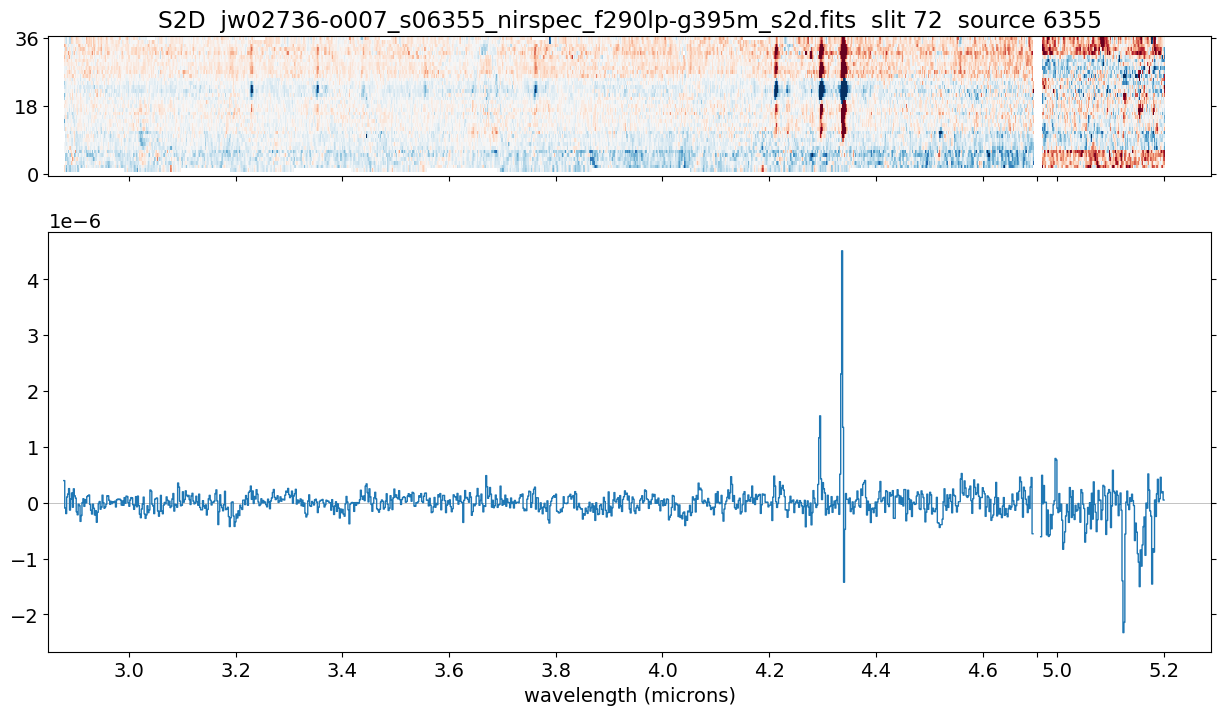

In [8]:
show_MOS_spectrum(s2d_model, x1d_model, source_id) # , cmap=cmap, bad_color=bad_color)

Note the 1D extraction sometimes misses the signal. This can be improved significantly simply by tweaking the extraction rows ystart – ystop as we'll demonstrate in another notebook in prep. Also note the x1d file doesn't save the ystart – ystop range used. Above, the center row is marked on the y axis.

## S2D ERROR array

In [9]:
cmap = 'viridis'
bad_color = 1, 0.7, 0.7
cmap = matplotlib.colormaps[cmap]
cmap.set_bad(bad_color, 1.)

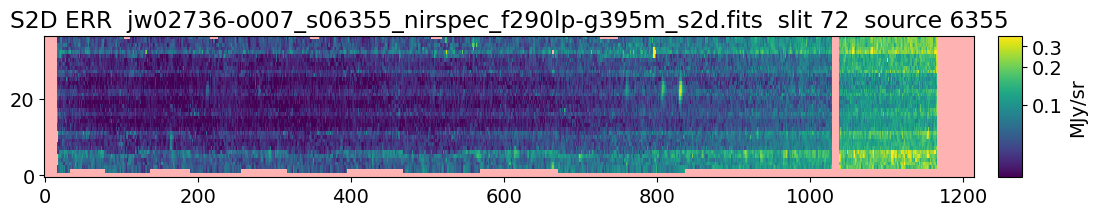

In [10]:
# Error array
s2d_err = s2d_model.err + 0
s2d_err = np.where(s2d_err, s2d_err, np.nan)  # Replace zeros with nan where there is no data
data = s2d_err + 0
#data = np.where(np.isnan(s2d_err), np.nan, data)

fig, ax = plt.subplots(1, 1, figsize=(12,3))
norm = simple_norm(data, 'asinh', min_percent=2, max_percent=99.925)
im = ax.imshow(data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
title = 'S2D ERR  ' + os.path.basename(s2d_model.meta.filename) + '  slit %d' % s2d_model.slitlet_id + '  source %d' % s2d_model.source_id
plt.title(title)
units = 'MJy/sr'
ax.set_aspect(5)
#plt.colorbar(im, ax=ax, label=units, aspect=5, pad=0.02, shrink=0.51)
cbar_ax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.02, ax.get_position().height]) # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
fig.colorbar(im, label=units, cax=cbar_ax)

## S2D datamodel contents

In [11]:
s2d_model.info()  
#s2d_model.info(max_rows=99999)  # show entire contents

root (AsdfObject)
├─asdf_library (Software) ...
├─history (dict) ...
├─_fits_hash (str): 3f6ab50ab6ea20d518ae5fffa2fe7ee0363929dfd898de80dd6bd0dec587358b
├─con (ndarray): shape=(1, 37, 1215), dtype=int32
├─data (ndarray): shape=(37, 1215), dtype=float32
├─err (ndarray): shape=(37, 1215), dtype=float32
├─hdrtab (FITS_rec): shape=(6,), dtype=record34352
├─meta (dict) ...
├─name (str): 72
├─shutter_id (int): 30433
├─shutter_state (str): 1x111
├─slitlet_id (int): 72
├─source_alias (str): 6355
├─source_dec (float): -73.4350589621277
├─source_id (int): 6355
├─source_name (str): 2736_6355
├─source_ra (float): 110.84459416965377
├─source_type (str): EXTENDED
├─source_xpos (float): -0.0356217622756958
├─source_ypos (float): 0.36562544107437134
├─stellarity (float): 0.1
└─8 not shown
Some nodes not shown.


In [12]:
s2d_model.__dict__['_instance'].keys()

dict_keys(['asdf_library', 'history', '_fits_hash', 'con', 'data', 'err', 'hdrtab', 'meta', 'name', 'shutter_id', 'shutter_state', 'slitlet_id', 'source_alias', 'source_dec', 'source_id', 'source_name', 'source_ra', 'source_type', 'source_xpos', 'source_ypos', 'stellarity', 'var_flat', 'var_poisson', 'var_rnoise', 'wht', 'xsize', 'xstart', 'ysize', 'ystart'])

In [13]:
s2d_model.source_ra, s2d_model.source_dec

(110.84459416965377, -73.4350589621277)

In [14]:
list(s2d_model)

['asdf_library.author',
 'asdf_library.homepage',
 'asdf_library.name',
 'asdf_library.version',
 'history.extensions',
 '_fits_hash',
 'con',
 'data',
 'err',
 'hdrtab',
 'meta.aperture.name',
 'meta.aperture.position_angle',
 'meta.aperture.pps_name',
 'meta.asn.exptype',
 'meta.asn.pool_name',
 'meta.asn.table_name',
 'meta.bunit_data',
 'meta.bunit_err',
 'meta.cal_step.assign_wcs',
 'meta.cal_step.back_sub',
 'meta.cal_step.barshadow',
 'meta.cal_step.dark_sub',
 'meta.cal_step.dq_init',
 'meta.cal_step.extract_2d',
 'meta.cal_step.flat_field',
 'meta.cal_step.gain_scale',
 'meta.cal_step.group_scale',
 'meta.cal_step.imprint',
 'meta.cal_step.ipc',
 'meta.cal_step.jump',
 'meta.cal_step.linearity',
 'meta.cal_step.master_background',
 'meta.cal_step.msa_flagging',
 'meta.cal_step.outlier_detection',
 'meta.cal_step.pathloss',
 'meta.cal_step.photom',
 'meta.cal_step.pixel_replace',
 'meta.cal_step.ramp_fit',
 'meta.cal_step.refpix',
 'meta.cal_step.resample',
 'meta.cal_step.satu

In [15]:
s2d_model.meta.cal_step.__dict__['_instance']

{'assign_wcs': 'COMPLETE',
 'back_sub': 'COMPLETE',
 'barshadow': 'COMPLETE',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'extract_2d': 'COMPLETE',
 'flat_field': 'COMPLETE',
 'gain_scale': 'COMPLETE',
 'group_scale': 'COMPLETE',
 'imprint': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'linearity': 'COMPLETE',
 'master_background': 'SKIPPED',
 'msa_flagging': 'COMPLETE',
 'outlier_detection': 'COMPLETE',
 'pathloss': 'COMPLETE',
 'photom': 'COMPLETE',
 'pixel_replace': 'SKIPPED',
 'ramp_fit': 'COMPLETE',
 'refpix': 'COMPLETE',
 'resample': 'COMPLETE',
 'saturation': 'COMPLETE',
 'srctype': 'COMPLETE',
 'superbias': 'COMPLETE'}

In [16]:
s2d_model.meta.cal_step.master_background

'SKIPPED'

In [17]:
s2d_model.meta.cal_step.__getattr__('pathloss')

'COMPLETE'

## X1D datamodel contents

In [18]:
x1d_model.info()  

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.15.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 4190c5ef01fd3a52c43d2c6df6a9c56726cc3ecef156be05ce1e0851a20429e6
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─asn (dict) ...
│ ├─background (dict)
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ ├─calibration_software_version (str): 1.11.4
│ ├─compress (bool): False
│ ├─data_processing_software_version (str): 2023_2a
│ ├─date (str): 2023-11-18T06:34:36.548
│ ├─dither (dict) ...
│ ├─exposure (dict) ...
│ └─23 not shown
└─spec (list) ...
Some nodes not shown.


In [19]:
#list(x1d_model.spec[0])
x1d_model.spec[0].__dict__['_instance'].keys()

dict_keys(['dispersion_direction', 'meta', 'name', 'shutter_state', 'slit_dec', 'slit_ra', 'slitlet_id', 'source_alias', 'source_dec', 'source_id', 'source_name', 'source_ra', 'source_type', 'source_xpos', 'source_ypos', 'spec_table', 'spectral_order', 'stellarity'])

In [20]:
x1d_model.__dict__['_instance'].keys()

dict_keys(['asdf_library', 'history', '_fits_hash', 'meta', 'spec'])